<a href="https://colab.research.google.com/github/IbrahimEnouali/EC-DataScience-Coursework/blob/main/Graph-Analytics/GNN_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Réseaux de neurones graphiques à base d'Attention.

Dans ce TP, nous nous proposons d'étudier le dataset Cora. Celui-ci est composé de 2708 papiers scientifiques répartis en sept classes. L'objectif de ce TP est de construire un modèle permettant de prédire la classe à laquelle appartient un noeud (papier scientifique).



In [ ]:
import os
import torch
import networkx as nx
import pandas as pd
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Analyse du dataset Cora

On se propose ici d'explorer le dataset Cora. Il est fortement recommandé de compléter cette analyse exploratoire (visualiser le graphe, etc.).

In [ ]:
dataset = Planetoid(root='~/somewhere/Cora', name='Cora')
data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


# Plot Dataset

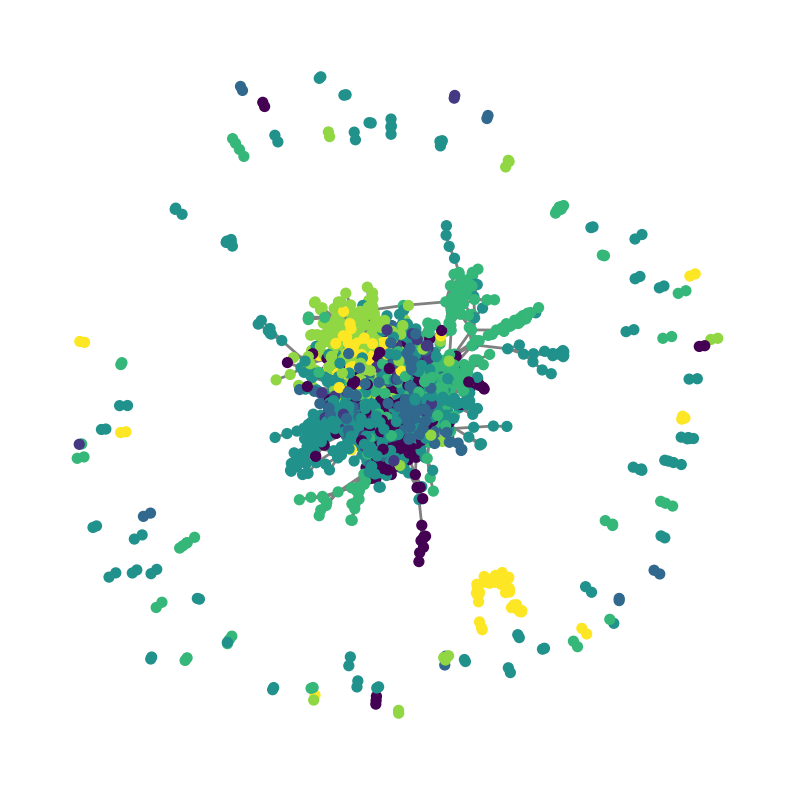

In [ ]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10,10))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

# Question 1 : construire un modèle à base de GAT qui permet de prédire la classe à laquelle appartient un noeud.
---



In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 300
    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
%%time
# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)
# Train
train(gat, data)
# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(1433, 8, heads=8)
  (gat2): GATv2Conv(64, 7, heads=1)
)
Epoch   0 | Train Loss: 1.925 | Train Acc:  19.29% | Val Loss: 1.93 | Val Acc: 22.60%
Epoch  10 | Train Loss: 0.325 | Train Acc:  97.86% | Val Loss: 0.92 | Val Acc: 77.00%
Epoch  20 | Train Loss: 0.055 | Train Acc:  99.29% | Val Loss: 0.87 | Val Acc: 74.00%
Epoch  30 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 1.03 | Val Acc: 72.00%
Epoch  40 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.09 | Val Acc: 72.80%
Epoch  50 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.10 | Val Acc: 72.00%
Epoch  60 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.09 | Val Acc: 72.40%
Epoch  70 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.10 | Val Acc: 72.60%
Epoch  80 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 1.07 | Val Acc: 72.60%
Epoch  90 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0.98 | Val Acc: 73.60%
Epoch 100 | Train Loss: 0.009 | Train Acc: 100.00% | Val Lo

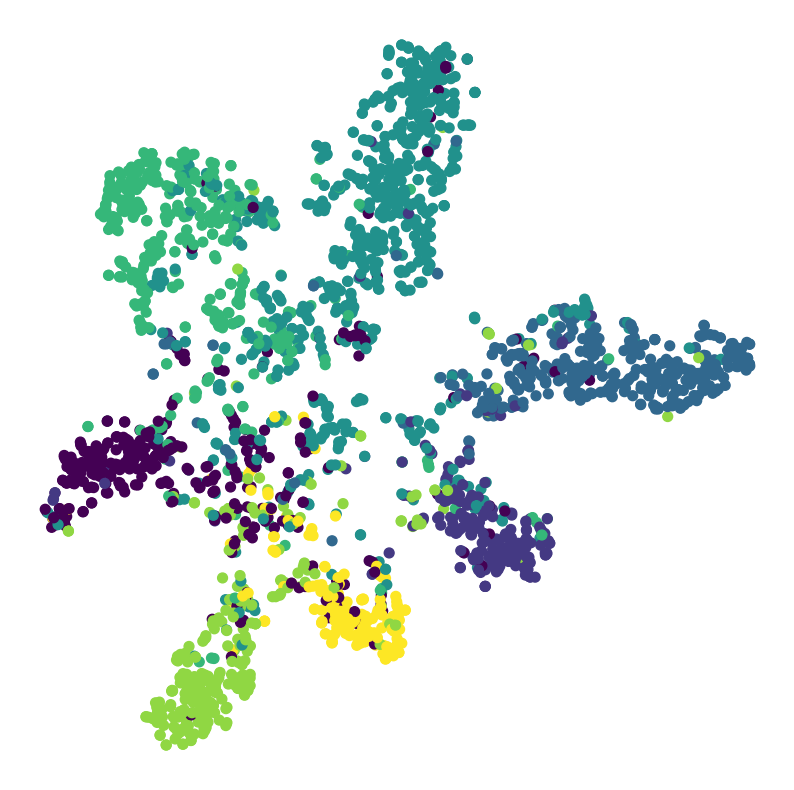

In [ ]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)
# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())
# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()